### Applied DYNOTEARS Algorithm

In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

feature_matrix = pd.read_parquet(
    '../data/feature_matrix.parquet',
)

In [254]:
# feature_matrix = feature_matrix.resample('W-FRI').last()

### PCMCI models

In [193]:
from tigramite.data_processing import DataFrame as TigDataFrame
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.pcmci import PCMCI

import networkx as nx

def make_link_assumptions(
        var_names,
        tau_max,
        macro_vars,
        cluster_vars
    ) :
    """
    tigramite PCMCI의 link_assumptions:
    link_assumptions[j][i][tau] = "?"(allow) or "0"(forbid)

    X^i_{t-tau} -> X^j_t
    """
    name_to_idx = {n: i for i, n in enumerate(var_names)}
    macro_idx   = {name_to_idx[n] for n in macro_vars if n in name_to_idx}
    cluster_idx = {name_to_idx[n] for n in cluster_vars if n in name_to_idx}

    n = len(var_names)

    # 1) 기본: 모든 "시차 링크" 허용 (튜플 key: (source_idx, -tau))
    link_assumptions = {}
    for j in range(n):
        links_j = {}
        for i in range(n):
            for tau in range(1, tau_max + 1):
                links_j[(i, -tau)] = "o->"  # lagged link (방향은 시간상 i_{t-tau} -> j_t)
        link_assumptions[j] = links_j

    # 2) 제약: Cluster -> Macro 금지 (모든 lag에서 삭제)
    for j in macro_idx:
        for i in cluster_idx:
            for tau in range(1, tau_max + 1):
                link_assumptions[j].pop((i, -tau), None)

    return link_assumptions

In [150]:
def run_pcmci(final_feature_matrix: pd.DataFrame,
              tau_max: int = 5,
              pc_alpha: float = 0.1,
              alpha_level: float = 0.05,
              macro_vars=None,
              cluster_vars=None):

    df = final_feature_matrix.copy()

    # tigramite는 numpy array를 받음 (결측 제거 권장)
    df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
    var_names = list(df.columns)

    if macro_vars is None:
        macro_vars = ["USOIL", "TBILL", "COPPER", "DXY", "HYS", "BEI", "VIX"]
    if cluster_vars is None:
        cluster_vars = [c for c in var_names if c.lower().startswith("cluster")]

    tig_df = TigDataFrame(df.values, var_names=var_names)

    parcorr = ParCorr(significance="analytic")
    pcmci = PCMCI(dataframe=tig_df, cond_ind_test=parcorr, verbosity=1)

    link_assumptions = make_link_assumptions(
        var_names=var_names,
        tau_max=tau_max,
        macro_vars=macro_vars,
        cluster_vars=cluster_vars
    )

    results = pcmci.run_pcmci(
        tau_max=tau_max,
        pc_alpha=pc_alpha,
        alpha_level=alpha_level,
        link_assumptions=link_assumptions
    )

    return results, var_names, df

def pcmci_to_nx(
        results,
        var_names,
        alpha_level=0.05
    ) -> nx.Graph:
    p = results["p_matrix"]      # shape: [N, N, tau_max+1] or [N, N, tau_max]
    val = results["val_matrix"]
    tau_max = p.shape[2] - 1

    G = nx.DiGraph()

    # 노드 생성 (t, t-1,...t-tau_max)
    for name in var_names:
        for lag in range(tau_max + 1):
            G.add_node(f"{name}@t-{lag}")

    for j, tgt in enumerate(var_names):
        for i, src in enumerate(var_names):
            for tau in range(1, tau_max + 1):  # tau=0(동시) 제외(원하면 포함 가능)
                if p[j, i, tau] <= alpha_level:
                    u = f"{src}@t-{tau}"
                    v = f"{tgt}@t-0"
                    G.add_edge(u, v, weight=float(val[j, i, tau]), pval=float(p[j, i, tau]))

    return G

def confounders_only(G: nx.DiGraph, treatment: str, outcome: str):
    """
    treatment: "X@t-k"
    outcome:   "Y@t-0"
    confounder = Ancestors(treatment) ∩ Ancestors(outcome)
    collider는 '공통결과'를 조건화할 때 생기므로, 공통원인만 고르면 collider conditioning을 크게 줄일 수 있음.
    """
    anc_t = nx.ancestors(G, treatment)
    anc_y = nx.ancestors(G, outcome)

    common = anc_t.intersection(anc_y)

    common = {z for z in common if z not in {treatment, outcome}}

    return sorted(common)

In [5]:
import statsmodels.api as sm

def estimate_effect_hac(df_raw: pd.DataFrame,
                        treatment_var: str,
                        outcome_var: str,
                        lags_for_treatment: int,
                        control_nodes: list,
                        hac_lags: int = 5):
    """
    df_raw: 원래 t 시계열 데이터프레임(열: USOIL..Cluster_3)
    treatment_var: 예) "VIX"
    outcome_var: 예) "Cluster_1"
    lags_for_treatment: 예) 1 => VIX(t-1)로 개입
    control_nodes: ["DXY@t-1", "TBILL@t-2", ...] 형태
    """

    df = df_raw.copy()

    # outcome: Y_t
    y = df[outcome_var]

    # treatment: X_{t-k}
    x = df[treatment_var].shift(lags_for_treatment)

    X = pd.DataFrame({"treat": x})

    # controls: Z_{t-l}
    for node in control_nodes:
        name, lag = node.split("@t-")
        lag = int(lag)
        X[node] = df[name].shift(lag)

    data = pd.concat([y, X], axis=1).dropna()
    y2 = data[outcome_var]
    X2 = sm.add_constant(data.drop(columns=[outcome_var]))

    model = sm.OLS(y2, X2).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})
    return model

In [6]:
from tqdm import tqdm

def automated_pipeline(
        final_feature_matrix: pd.DataFrame,
        tau_max: int = 5,
        pc_alpha: float = 0.1,
        alpha_level: float = 0.05
    ):

    results, var_names, df_clean = run_pcmci(
        final_feature_matrix,
        tau_max=tau_max,
        pc_alpha=pc_alpha,
        alpha_level=alpha_level
    )

    G = pcmci_to_nx(results, var_names, alpha_level=alpha_level)

    macro_vars = ["USOIL", "TBILL", "COPPER", "DXY", "HYS", "BEI", "VIX"]
    cluster_vars = ["Cluster_1", "Cluster_2", "Cluster_3"]

    rows = []

    # treatment는 macro의 lagged value만 개입(예: t-1..t-tau_max)
    for X in tqdm(macro_vars):
        for Y in cluster_vars:
            for k in range(1, tau_max + 1):
                treat_node = f"{X}@t-{k}"
                out_node = f"{Y}@t-0"

                Z = confounders_only(G, treat_node, out_node)

                # HAC 회귀로 효과추정
                try:
                    m = estimate_effect_hac(
                        df_raw=df_clean,
                        treatment_var=X,
                        outcome_var=Y,
                        lags_for_treatment=k,
                        control_nodes=Z,
                        hac_lags=tau_max
                    )
                    rows.append({
                        "treatment": X,
                        "treat_lag": k,
                        "outcome": Y,
                        "n_controls": len(Z),
                        "controls": Z,
                        "coef": float(m.params.get("treat", np.nan)),
                        "tstat": float(m.tvalues.get("treat", np.nan)),
                        "pval": float(m.pvalues.get("treat", np.nan)),
                        "r2": float(m.rsquared),
                        "nobs": int(m.nobs),
                    })
                except Exception as e:
                    rows.append({
                        "treatment": X,
                        "treat_lag": k,
                        "outcome": Y,
                        "n_controls": len(Z),
                        "controls": Z,
                        "coef": np.nan,
                        "tstat": np.nan,
                        "pval": np.nan,
                        "r2": np.nan,
                        "nobs": 0,
                        "error": str(e),
                    })

    effects = pd.DataFrame(rows).sort_values(["outcome", "treatment", "treat_lag"])
    return results, G, effects

In [7]:
results, graph, effects = automated_pipeline(
    final_feature_matrix = feature_matrix,
    tau_max = 1,
    pc_alpha = 0.1,
    alpha_level = 0.05,
)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
link_assumptions = {0: {(0, -1): 'o->', (1, -1): 'o->', (2, -1): 'o->', (3, -1): 'o->', (4, -1): 'o->', (5, -1): 'o->', (6, -1): 'o->'}, 1: {(0, -1): 'o->', (1, -1): 'o->', (2, -1): 'o->', (3, -1): 'o->', (4, -1): 'o->', (5, -1): 'o->', (6, -1): 'o->'}, 2: {(0, -1): 'o->', (1, -1): 'o->', (2, -1): 'o->', (3, -1): 'o->', (4, -1): 'o->', (5, -1): 'o->', (6, -1): 'o->'}, 3: {(0, -1): 'o->', (1, -1): 'o->', (2, -1): 'o->', (3, -1): 'o->', (4, -1): 'o->', (5, -1): 'o->', (6, -1): 'o->'}, 4: {(0, -1): 'o->', (1, -1): 'o->', (2, -1): 'o->', (3, -1): 'o->', (4, -1): 'o->', (5, -1): 'o->', (6, -1): 'o->'}, 5: {(0, -1): 'o->', (1, -1): 'o->', (2, -1): 'o->', (3, -1): 'o->', (4, -1): 'o->', (5, -1): 'o->', (6, -1): 'o->'}, 6: {(0, -1): 'o->', (1, -1): 'o->', (2, -1): 'o->', (3, -1): 'o->', (4, -1): 'o->', (5, -1): 'o->', (6, -1): 'o->'}, 7: {(0, -1): 'o->', (1, -1): 'o->', (2, -1): 'o->', (3, -1): 'o->', (4, -1): 'o->', 

100%|██████████| 7/7 [00:00<00:00, 186.47it/s]


In [8]:
macro_vars = ["USOIL", "TBILL", "COPPER", "DXY", "HYS", "BEI", "VIX"]
cluster_vars = ["Cluster_1", "Cluster_2", "Cluster_3"]

def _base_name(node: str) -> str:
    # 'USOIL@t-0' -> 'USOIL'
    return str(node).split("@", 1)[0]


def plot_graph_tree(G: nx.DiGraph, macro_vars=None, cluster_prefix="Cluster_", figsize=(14, 8)):
    if macro_vars is None:
        macro_vars = ["USOIL", "TBILL", "COPPER", "DXY", "HYS", "BEI", "VIX"]

    nodes = list(G.nodes())

    macro_nodes = [n for n in nodes if any(n.startswith(m) for m in macro_vars)]
    cluster_nodes = [n for n in nodes if n.startswith(cluster_prefix)]
    other_nodes = [n for n in nodes if n not in macro_nodes + cluster_nodes]

    pos = {}

    # 좌측: 매크로
    y_macro = np.linspace(1, -1, len(macro_nodes))
    for i, n in enumerate(sorted(macro_nodes)):
        pos[n] = (0.0, y_macro[i])

    # 중앙: 기타 (있으면)
    y_mid = np.linspace(1, -1, len(other_nodes)) if other_nodes else []
    for i, n in enumerate(sorted(other_nodes)):
        pos[n] = (1.5, y_mid[i])

    # 우측: 클러스터
    y_cluster = np.linspace(1, -1, len(cluster_nodes))
    for i, n in enumerate(sorted(cluster_nodes)):
        pos[n] = (3.0, y_cluster[i])

    plt.figure(figsize=figsize)

    nx.draw_networkx_nodes(G, pos, nodelist=macro_nodes, node_size=1200)
    nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_size=900)
    nx.draw_networkx_nodes(G, pos, nodelist=cluster_nodes, node_size=1200)

    nx.draw_networkx_labels(G, pos, font_size=9)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="->", width=1.2, alpha=0.7)

    plt.axis("off")
    plt.show()

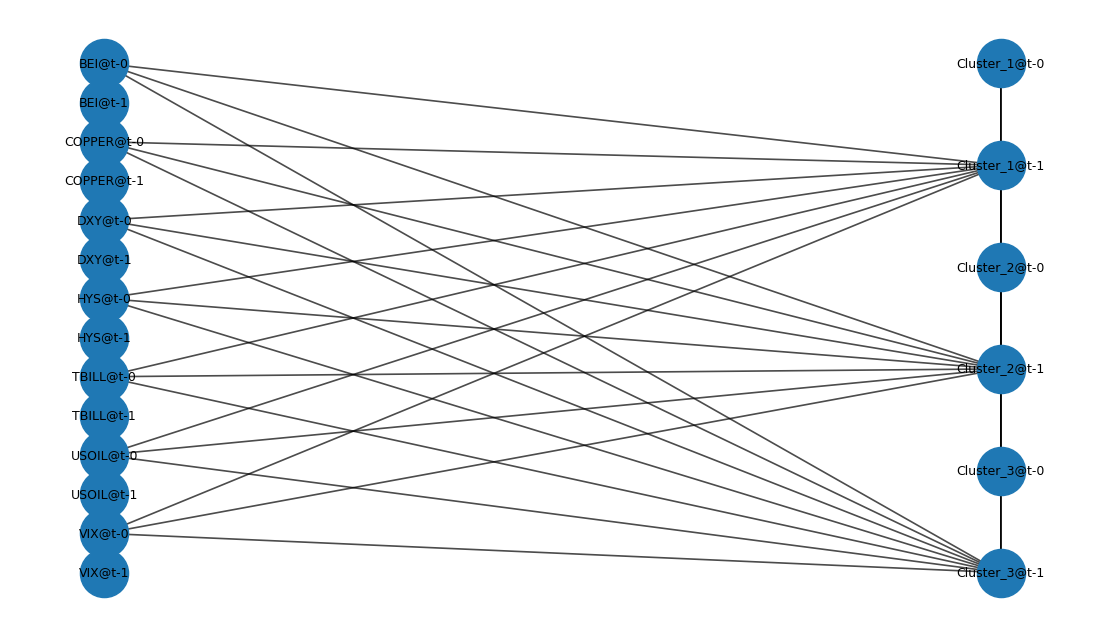

In [9]:
plot_graph_tree(graph)

### use LiNGRAM, delete time lag

In [255]:
from sklearn.preprocessing import StandardScaler
from lingam import DirectLiNGAM


def _base_name(node: str) -> str:
    # "USOIL@t-0" -> "USOIL"
    return node.split("@")[0]


def collapse_to_static(df: pd.DataFrame) -> pd.DataFrame:
    """
    @t-0/@t-1 같은 시차 표기를 가진 컬럼을 정적(시차 제거) 컬럼으로 변환.
    - @t-0가 있으면 @t-0만 사용
    - @t-0가 없으면 그냥 원 컬럼 사용
    - 동일 base_name 중복 발생 시 첫 번째만 사용(필요하면 사용자 정책으로 바꾸세요)
    """
    cols = list(df.columns)
    has_lag = any("@t-" in c for c in cols)

    if not has_lag:
        return df.copy()

    # 우선 @t-0만 선택
    t0_cols = [c for c in cols if c.endswith("@t-0")]
    if len(t0_cols) == 0:
        # @t-0가 없다면 그냥 base_name별로 첫 컬럼 사용
        chosen = {}
        for c in cols:
            b = _base_name(c)
            if b not in chosen:
                chosen[b] = c
        out = df[list(chosen.values())].copy()
        out.columns = list(chosen.keys())
        return out

    out = df[t0_cols].copy()
    out.columns = [_base_name(c) for c in t0_cols]

    # base 중복 제거
    out = out.loc[:, ~out.columns.duplicated()]
    return out


def make_prior_knowledge(
    columns: list[str],
    macro_vars: list[str],
    cluster_vars: list[str],
    forbid_cluster_to_macro: bool = True,
    extra_forbidden_edges: list[tuple[str, str]] | None = None,
):
    """
    lingam 버전 차이를 흡수:
      - PriorKnowledge 객체 반환 버전
      - numpy.ndarray 반환 버전 모두 지원
    """
    col_to_idx = {c: i for i, c in enumerate(columns)}
    p = len(columns)

    # 1) 객체 방식 시도
    try:
        from lingam.utils import PriorKnowledge
        pk = PriorKnowledge(n_variables=p)

        def forbid(i, j):
            pk.add_forbidden_edge(i, j)

        is_object = True

    except Exception:
        # 2) 행렬 방식 (numpy.ndarray)
        from lingam.utils import make_prior_knowledge as _make_pk
        pk = _make_pk(n_variables=p)

        def forbid(i, j):
            pk[i, j] = -1

        is_object = False

    def forbid_by_name(src: str, dst: str):
        if src in col_to_idx and dst in col_to_idx:
            forbid(col_to_idx[src], col_to_idx[dst])

    # Cluster -> Macro 금지
    if forbid_cluster_to_macro:
        for c in cluster_vars:
            for m in macro_vars:
                forbid_by_name(c, m)

    # 추가 금지 간선
    if extra_forbidden_edges:
        for src, dst in extra_forbidden_edges:
            forbid_by_name(src, dst)

    return pk

In [256]:
from networkx.drawing.nx_agraph import graphviz_layout

def build_forbid_edges(
    cols: list[str],
    macro_vars: list[str],
    tbill_policy: str = "relaxed",  # "strict" or "relaxed"
):
    """
    tbill_policy
      - "strict": TBILL을 항상 원인으로 유도 (others -> TBILL 금지)
      - "relaxed": TBILL이 일부 변수의 결과일 가능성 허용 (macro들만 -> TBILL 금지)

    LiNGAM prior는 허용을 강제할 수 없으므로,
    방향성(예: TBILL이 원인)은 반대방향 금지로 구현합니다.
    """
    forbid_edges: list[tuple[str, str]] = []

    # (3) 명시 금지
    # (USOIL, COPPER) -> DXY 금지
    if "DXY" in cols:
        for src in ("USOIL", "COPPER"):
            if src in cols:
                forbid_edges.append((src, "DXY"))

    # HYS -> VIX 금지
    if "HYS" in cols and "VIX" in cols:
        forbid_edges.append(("HYS", "VIX"))

    # (1) TBILL 관련: 강제(Strict) vs 완화(Relaxed)
    if "TBILL" in cols:
        if tbill_policy == "strict":
            # others -> TBILL 금지 (가장 강함)
            for v in cols:
                if v != "TBILL":
                    forbid_edges.append((v, "TBILL"))
        elif tbill_policy == "relaxed":
            # macro들만 -> TBILL 금지 (완화)
            for v in macro_vars:
                if v in cols and v != "TBILL":
                    forbid_edges.append((v, "TBILL"))
        else:
            raise ValueError("tbill_policy must be 'strict' or 'relaxed'.")

    return forbid_edges


def fit_lingam_static(
    feature_matrix: pd.DataFrame,
    macro_vars=("USOIL", "TBILL", "COPPER", "DXY", "HYS", "BEI", "VIX"),
    cluster_prefix="Cluster_",
    standardize: bool = True,
    random_state: int = 7,
    tbill_policy: str = "relaxed",   # "strict" or "relaxed"
):
    """
    시차 제거 + prior 적용 + DirectLiNGAM 적합.

    포함된 설계 원칙
      1) TBILL 방향성 제약은 '허용 강제'가 아니라 '반대방향 금지'로 구현
         - strict: others -> TBILL 금지 (TBILL root 강제에 가까움)
         - relaxed: macro들만 -> TBILL 금지 (TBILL이 cluster/기타의 결과일 가능성 일부 허용)
      2) LiNGAM prior는 허용을 강제하기 어렵고, 금지로만 탐색공간을 줄입니다.

    반환:
      model, B, order, df_used
      - B[i, j] = i -> j 가중치 (lingam adjacency_matrix_ convention)
    """
    df0 = collapse_to_static(feature_matrix)

    macro_vars = list(macro_vars)
    cluster_vars = [c for c in df0.columns if str(c).startswith(cluster_prefix)]

    df = df0.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any").copy()

    X = df.values
    if standardize:
        X = StandardScaler().fit_transform(X)

    cols = list(df.columns)
    forbid_edges = build_forbid_edges(
        cols=cols,
        macro_vars=macro_vars,
        tbill_policy=tbill_policy,
    )

    pk = make_prior_knowledge(
        columns=cols,
        macro_vars=macro_vars,
        cluster_vars=cluster_vars,
        forbid_cluster_to_macro=True,
        extra_forbidden_edges=forbid_edges,
    )

    model = DirectLiNGAM(prior_knowledge=pk, random_state=random_state)
    model.fit(X)

    B = model.adjacency_matrix_.copy()   # B[i, j] = i -> j
    order = model.causal_order_

    return model, B, order, df


def adjacency_to_digraph(B: np.ndarray, columns: list[str], thresh: float = 1e-6) -> nx.DiGraph:
    G = nx.DiGraph()
    G.add_nodes_from(columns)

    p = len(columns)
    for i in range(p):
        for j in range(p):
            w = B[i, j]
            if abs(w) > thresh:
                G.add_edge(columns[i], columns[j], weight=float(w))
    return G


def plot_treeish(
        G : nx.DiGraph,
        figsize : tuple = (14, 9),
        font_size : int = 9,
        min_width : float = 0.5,
        max_width : float = 4.0,
        show_weights : bool = True,
        arrowsize : int = 20,          # 화살표 머리 크기
        arrowstyle = "-|>"
    ) -> None :     # 화살표 모양(굵고 명확)

    pos = graphviz_layout(G, prog="dot")  # 계층 DAG 레이아웃

    edges = list(G.edges(data=True))
    if len(edges) > 0:
        w_abs = np.array([abs(d.get("weight", 1.0)) for _, _, d in edges])
        w_min, w_max = w_abs.min(), w_abs.max()
        if w_max > w_min:
            widths = min_width + (w_abs - w_min) / (w_max - w_min) * (max_width - min_width)
        else:
            widths = np.full_like(w_abs, (min_width + max_width) / 2)
    else:
        widths = []

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos, node_size=900)
    nx.draw_networkx_labels(G, pos, font_size=font_size)
    nx.draw_networkx_edges(
        G, pos,
        arrows=True,
        arrowstyle=arrowstyle,
        arrowsize=arrowsize,   # 여기
        width=widths
    )

    if show_weights and len(edges) > 0:
        edge_labels = {(u, v): f"{d.get('weight', 0.0):.2f}" for u, v, d in edges}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.axis("off")
    plt.show()

In [257]:
model, B, order, df_used = fit_lingam_static(feature_matrix)

In [258]:
graph = adjacency_to_digraph(B, df_used.columns, thresh=1e-4)

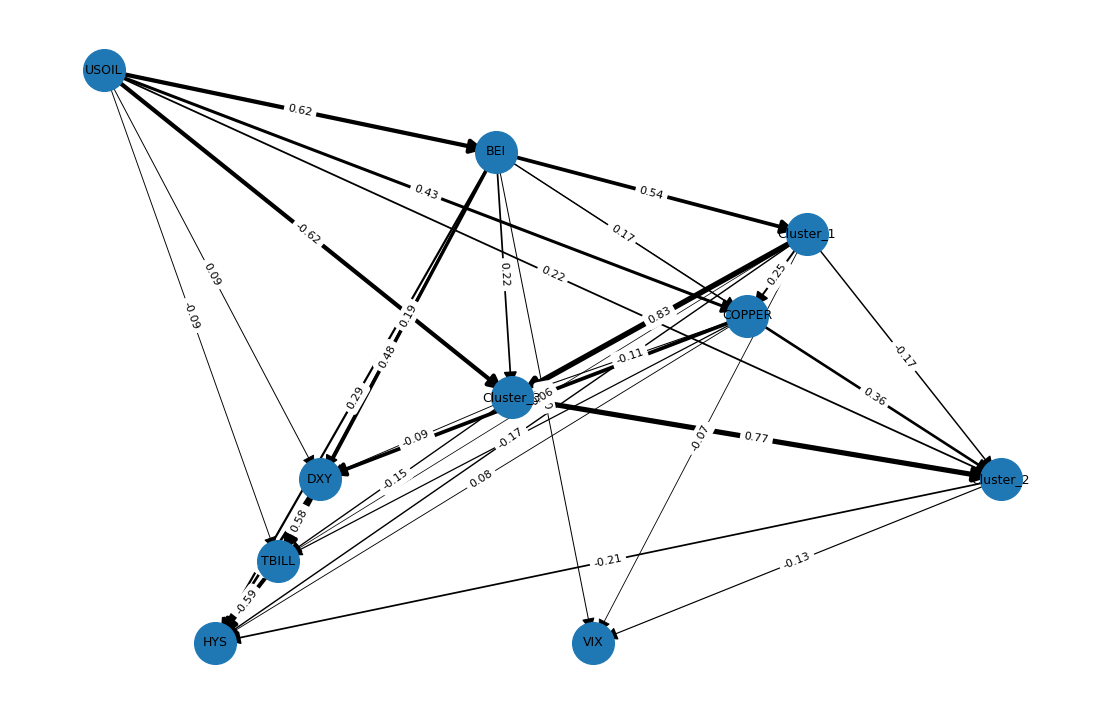

In [259]:
plot_treeish(graph)

### Identify Confounder, Collider, Mediator

In [260]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from econml.dml import LinearDML, CausalForestDML

def lingam_B_to_dag(B: np.ndarray, var_names: list[str], weight_threshold: float = 1e-8) -> nx.DiGraph:
    """
    B[i, j] : (j -> i) 계수라고 가정하는 표준 SEM 표기( x = Bx + e )
    즉, B[target, source] = weight
    """
    G = nx.DiGraph()
    G.add_nodes_from(var_names)

    p = len(var_names)
    for target in range(p):
        for source in range(p):
            w = B[target, source]
            if abs(w) > weight_threshold:
                G.add_edge(var_names[source], var_names[target], weight=float(w))
    return G

In [261]:
def _proper_ancestors(G: nx.DiGraph, node: str) -> set[str]:
    return nx.ancestors(G, node)

def _proper_descendants(G: nx.DiGraph, node: str) -> set[str]:
    return nx.descendants(G, node)

def _as_2d(a):
    a = np.asarray(a)
    if a.ndim == 1:
        a = a.reshape(-1, 1)
    return a

def find_mediators(G: nx.DiGraph, T: str, Y: str) -> set[str]:
    """
    Mediator: T -> ... -> M -> ... -> Y 형태로
    M이 (T의 descendant) 이면서 (Y의 ancestor) 인 노드
    """
    med = (_proper_descendants(G, T) & _proper_ancestors(G, Y)) - {T, Y}
    return med

def find_confounders(G: nx.DiGraph, T: str, Y: str) -> set[str]:
    """
    Confounder 후보: T와 Y의 공통 원인
    W ∈ Anc(T) ∩ Anc(Y)
    """
    conf = (_proper_ancestors(G, T) & _proper_ancestors(G, Y)) - {T, Y}
    return conf

def find_colliders_on_paths(G: nx.DiGraph, T: str, Y: str, max_simple_paths: int = 2000) -> set[str]:
    """
    Collider 후보:
    T와 Y 사이의 단순 경로(무방향으로 취급) 중에서,
    어떤 노드 v가 경로 상에서 양쪽 이웃 u,w로부터 u->v 그리고 w->v 가 동시에 성립하면 collider로 표시.
    (주의: 이는 '경로 상의 collider' 후보 탐지용 휴리스틱이며, 완전한 d-separation 판정은 아님)
    """
    UG = G.to_undirected()
    colliders = set()

    # 경로가 너무 많을 수 있으니 제한
    cnt = 0
    for path in nx.all_simple_paths(UG, source=T, target=Y):
        cnt += 1
        if cnt > max_simple_paths:
            break
        # 내부 노드에 대해 collider 여부 체크
        for i in range(1, len(path) - 1):
            u, v, w = path[i - 1], path[i], path[i + 1]
            if G.has_edge(u, v) and G.has_edge(w, v):
                colliders.add(v)
    return colliders

def classify_nodes_for_pair(G: nx.DiGraph, T: str, Y: str) -> dict[str, set[str]]:
    """
    Pair별로 confounder/mediator/collider 후보를 분리.
    우선순위:
    - mediator는 '조절하면 direct effect'가 되므로 별도 관리
    - collider는 절대 조절하지 않도록 별도 관리
    - confounder는 조절 후보
    """
    mediators = find_mediators(G, T, Y)
    confounders = find_confounders(G, T, Y) - mediators
    colliders = find_colliders_on_paths(G, T, Y) - mediators - confounders - {T, Y}

    return {
        "confounders": confounders,
        "mediators": mediators,
        "colliders": colliders,
    }


In [262]:
def run_dml_effect(
    df: pd.DataFrame,
    T: str,
    Y: str,
    confounders: list[str],
    mediators: list[str],
    effect_type: str = "total",
    discrete_treatment: bool = False,
    model_y=None,
    model_t=None,
    final_model: str = "forest",
    random_state: int = 0,
):
    # y, t
    y = df[Y].to_numpy()
    t = df[T].to_numpy()

    # X: confounders만 (요청대로 collider/mediator 제외)
    if confounders and len(confounders) > 0:
        X = df[confounders].to_numpy()
        X = _as_2d(X)
    else:
        # CausalForestDML은 X=None 불가 → 더미 상수열로 대체
        X = np.ones((len(df), 1), dtype=float)

    # W: effect_type="direct"일 때만 mediator를 W로 넣음(총효과면 None)
    if effect_type == "direct" and mediators and len(mediators) > 0:
        W = df[mediators].to_numpy()
        W = _as_2d(W)
    else:
        W = None

    # 기본 모델 세팅(외부에서 안 넣으면 내부에서 간단히 채움)
    if model_y is None or model_t is None:
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.linear_model import LassoCV

        if final_model == "forest":
            if model_y is None:
                model_y = RandomForestRegressor(
                    n_estimators=300, min_samples_leaf=10, random_state=random_state, n_jobs=-1
                )
            if model_t is None:
                model_t = RandomForestRegressor(
                    n_estimators=300, min_samples_leaf=10, random_state=random_state, n_jobs=-1
                )
        else:
            if model_y is None:
                model_y = LassoCV(cv=5, random_state=random_state)
            if model_t is None:
                model_t = LassoCV(cv=5, random_state=random_state)

    # Estimator
    if final_model == "forest":
        from econml.dml import CausalForestDML
        est = CausalForestDML(
            model_y=model_y,
            model_t=model_t,
            discrete_treatment=discrete_treatment,
            n_estimators=500,
            min_samples_leaf=10,
            random_state=random_state,
        )
    else:
        from econml.dml import LinearDML
        est = LinearDML(
            model_y=model_y,
            model_t=model_t,
            discrete_treatment=discrete_treatment,
            random_state=random_state,
        )

    est.fit(y, t, X=X, W=W)

    # ATE 요약
    eff = est.effect(X=X)
    ate = float(np.mean(eff))

    # 간단 CI(가능할 때만)
    ci95 = None
    try:
        inf = est.effect_interval(X=X, alpha=0.05)
        lo = float(np.mean(inf[0]))
        hi = float(np.mean(inf[1]))
        ci95 = (lo, hi)
    except Exception:
        pass

    return {"ate": ate, "ci95": ci95, "n_confounders": len(confounders), "n_mediators": len(mediators)}

In [263]:
def automated_dag_dml_pipeline(
    final_feature_matrix: pd.DataFrame,
    B_lingam: np.ndarray,
    macro_vars: list[str],
    cluster_vars: list[str],
    forbid_cluster_to_macro: bool = True,
    standardize: bool = True,
    effect_type: str = "total",     # "total" or "direct"
    final_model: str = "linear",    # "linear" or "forest"
    random_state: int = 0,
):
    """
    요구사항 반영:
    - 초기 DAG: LiNGAM B로 생성
    - 규칙: cluster1~3 -> macro 영향 금지 (원하면 간선 제거)
    - collider는 제어하지 않음: confounders만 X로 사용
    - mediator는 effect_type에 따라 (direct 효과일 때만) W로 넣음
    """

    df = final_feature_matrix.copy()

    # 표준화(권장: DML에서 모델 안정성)
    if standardize:
        scaler = StandardScaler()
        df.loc[:, :] = scaler.fit_transform(df.values)

    var_names = list(df.columns)
    G = lingam_B_to_dag(B_lingam, var_names)

    # 구조 제약: cluster -> macro 금지
    if forbid_cluster_to_macro:
        for c in cluster_vars:
            for m in macro_vars:
                if G.has_edge(c, m):
                    G.remove_edge(c, m)

    # 모든 (T, Y)쌍에 대해 분류 + DML
    results = []
    for T in tqdm(var_names):
        for Y in var_names:
            if T == Y:
                continue

            # 당신의 설정: cluster는 macro에 영향을 주지 않는다고 했으므로,
            # T가 cluster이고 Y가 macro면 스킵(또는 강제로 0으로 처리)
            if forbid_cluster_to_macro and (T in cluster_vars) and (Y in macro_vars):
                continue

            cls = classify_nodes_for_pair(G, T, Y)
            conf = sorted(list(cls["confounders"]))
            med = sorted(list(cls["mediators"]))
            col = sorted(list(cls["colliders"]))

            # collider는 절대 조절 변수에 넣지 않음
            # confounder만 X로 사용
            dml_out = run_dml_effect(
                df=df,
                T=T,
                Y=Y,
                confounders=conf,
                mediators=med,
                effect_type=effect_type,
                discrete_treatment=False,
                model_y=None,
                model_t=None,
                final_model=final_model,
                random_state=random_state,
            )

            results.append({
                "T": T,
                "Y": Y,
                "n_confounders": len(conf),
                "n_mediators": len(med),
                "n_colliders": len(col),
                "confounders": conf,
                "mediators": med,
                "colliders": col,
                "ate": dml_out["ate"],
                "ci95": dml_out["ci95"],
            })

    results_df = pd.DataFrame(results).sort_values(["T", "Y"]).reset_index(drop=True)
    return results_df, G

In [264]:
results_df, G0 = automated_dag_dml_pipeline(
    final_feature_matrix = feature_matrix,
    B_lingam = B,
    macro_vars = macro_vars,
    cluster_vars = cluster_vars,
    forbid_cluster_to_macro = True,
    standardize = True,
    effect_type = "direct",      # 또는 "direct"
    final_model = "forest",     # "linear"도 가능
    random_state = 0,
)

100%|██████████| 10/10 [01:49<00:00, 10.91s/it]


In [265]:
def plot_dag_dot(
    G: nx.DiGraph,
    root: str | None = None,
    rankdir: str = "LR",          # "LR" 좌→우, "TB" 위→아래
    figsize=(14, 8),
    node_size=900,
    font_size=9,
    min_width=0.5,
    max_width=4.0,
    show_weights=True,
    weight_fmt="{:.2f}",
    prune_abs_weight: float | None = None,   # 예: 0.05 주면 약한 엣지 제거
):
    # (선택) 약한 엣지 제거
    H = G.copy()
    if prune_abs_weight is not None:
        drop = []
        for u, v, d in H.edges(data=True):
            w = d.get("weight", 1.0)
            if abs(w) < prune_abs_weight:
                drop.append((u, v))
        H.remove_edges_from(drop)

    # root 기준으로 "계층"을 더 강하게 만들고 싶으면:
    # root를 주면 root에서 도달 가능한 서브그래프를 우선 사용
    if root is not None and root in H:
        reachable = set(nx.descendants(H, root)) | {root}
        # root와 무관한 노드도 같이 보려면 이 줄을 주석처리
        # H = H.subgraph(reachable).copy()

    # Graphviz dot 레이아웃
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        pos = graphviz_layout(
            H,
            prog="dot",
            args=f"-Grankdir={rankdir} -Goverlap=false -Gsplines=true -Gsep=0.6"
        )
    except Exception as e:
        raise ImportError(
            "Graphviz 레이아웃을 쓰려면 pygraphviz(또는 pydot)가 필요합니다. "
            "conda 환경이면 `conda install -c conda-forge pygraphviz`를 권장합니다."
        ) from e

    # 엣지 두께 스케일
    edges = list(H.edges(data=True))
    if edges:
        w_abs = np.array([abs(d.get("weight", 1.0)) for _, _, d in edges], dtype=float)
        w_min, w_max = float(w_abs.min()), float(w_abs.max())
        if w_max > w_min:
            widths = min_width + (w_abs - w_min) / (w_max - w_min) * (max_width - min_width)
        else:
            widths = np.full_like(w_abs, (min_width + max_width) / 2.0)
    else:
        widths = []

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(H, pos, node_size=node_size)
    nx.draw_networkx_labels(H, pos, font_size=font_size)

    nx.draw_networkx_edges(
        H, pos,
        arrows=True, arrowstyle="->",
        width=widths,
        connectionstyle="arc3,rad=0.08"  # 약간 휘게 해서 겹침 완화
    )

    if show_weights and edges:
        edge_labels = {(u, v): weight_fmt.format(d.get("weight", 0.0)) for u, v, d in edges}
        nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=8)

    plt.axis("off")
    plt.tight_layout()
    plt.show()

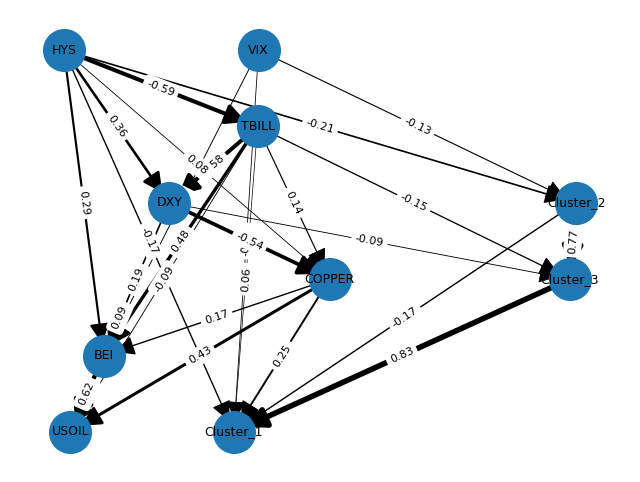

In [266]:
plot_treeish(
    G0,
    figsize = (8, 6),
    arrowsize = 30
)

In [267]:
results_df

,T,Y,n_confounders,n_mediators,n_colliders,confounders,mediators,colliders,ate,ci95
0,BEI,COPPER,3,0,4,"[DXY, HYS, TBILL]",[],"[Cluster_1, Cluster_2, Cluster_3, USOIL]",0.229505,"(0.051133406599442016, 0.4078773703447099)"
1,BEI,Cluster_1,5,0,3,"[COPPER, DXY, HYS, TBILL, VIX]",[],"[Cluster_2, Cluster_3, USOIL]",0.662369,"(0.5056717301981054, 0.8190670424134449)"
2,BEI,Cluster_2,2,0,5,"[HYS, VIX]",[],"[COPPER, Cluster_1, Cluster_3, DXY, USOIL]",0.583123,"(0.44774529319088696, 0.7185002968090154)"
3,BEI,Cluster_3,4,0,4,"[DXY, HYS, TBILL, VIX]",[],"[COPPER, Cluster_1, Cluster_2, USOIL]",0.732287,"(0.5694170043748765, 0.8951574777030127)"
4,BEI,DXY,2,0,5,"[HYS, TBILL]",[],"[COPPER, Cluster_1, Cluster_2, Cluster_3, USOIL]",-0.023561,"(-0.16460108594832643, 0.11747815363000895)"
...,...,...,...,...,...,...,...,...,...,...
64,VIX,Cluster_3,0,1,5,[],[Cluster_2],"[BEI, COPPER, Cluster_1, DXY, USOIL]",0.006225,"(-0.020360455595125095, 0.032810317910156206)"
65,VIX,DXY,0,0,6,[],[],"[BEI, COPPER, Cluster_1, Cluster_2, Cluster_3,...",0.003041,"(-0.027925774671478328, 0.034007122153624475)"
66,VIX,HYS,0,0,7,[],[],"[BEI, COPPER, Cluster_1, Cluster_2, Cluster_3,...",-0.022856,"(-0.0828787295365955, 0.03716703775619905)"
67,VIX,TBILL,0,0,7,[],[],"[BEI, COPPER, Cluster_1, Cluster_2, Cluster_3,...",-0.019693,"(-0.07644501787924397, 0.037059954930907066)"


In [268]:
def list_edges(G, sources, targets):
    out = []
    for s in sources:
        for t in targets:
            if G.has_edge(s, t):
                out.append((s, t, G[s][t].get("weight", np.nan)))
    return sorted(out, key=lambda x: -abs(x[2]))

edges_macro_to_cluster = list_edges(G0, macro_vars, cluster_vars)
edges_cluster_to_macro = list_edges(G0, cluster_vars, macro_vars)

edges_macro_to_cluster[:20], edges_cluster_to_macro[:20]

([('COPPER', 'Cluster_1', 0.25485464375082667),
  ('HYS', 'Cluster_2', -0.21426037199247283),
  ('HYS', 'Cluster_1', -0.16668977575153904),
  ('TBILL', 'Cluster_3', -0.15417727322542465),
  ('VIX', 'Cluster_2', -0.1258092216900914),
  ('DXY', 'Cluster_3', -0.08506385558605836),
  ('VIX', 'Cluster_1', -0.07320616230146947),
  ('TBILL', 'Cluster_1', 0.058448619900589485)],
 [])

In [269]:
def enforce_min_macro_parents_from_B(G, B, cols, macro_vars, cluster_vars, k=1):
    """
    B[i, j] = i -> j weight (사용자 코드 기준)
    그래프에 Macro->Cluster 엣지가 0개인 cluster가 있으면,
    |B[m, c]|가 큰 순으로 k개를 추가
    """
    col_to_idx = {c:i for i,c in enumerate(cols)}
    H = G.copy()

    for c in cluster_vars:
        if c not in col_to_idx:
            continue
        macro_parents = [p for p in H.predecessors(c) if p in macro_vars]
        if len(macro_parents) >= k:
            continue

        ci = col_to_idx[c]
        cand = []
        for m in macro_vars:
            if m not in col_to_idx:
                continue
            mi = col_to_idx[m]
            w = float(B[mi, ci])
            if abs(w) > 0:
                cand.append((m, c, w))

        cand = sorted(cand, key=lambda x: -abs(x[2]))
        need = k - len(macro_parents)
        for m, c, w in cand[:need]:
            H.add_edge(m, c, weight=w)

    return H

In [270]:
cols = list(df_used.columns)   # LiNGAM fit에 사용한 df 컬럼 순서
G1 = enforce_min_macro_parents_from_B(
    G0, B, cols,
    macro_vars,
    cluster_vars,
    k = 2
)

In [271]:
def prune_in_edges_topk(G, targets, k=3):
    H = G.copy()
    for t in targets:
        in_edges = [(u, v, H[u][v].get("weight", 0.0)) for u, v in H.in_edges(t)]
        in_edges = sorted(in_edges, key=lambda x: -abs(x[2]))
        keep = set((u, v) for u, v, _ in in_edges[:k])
        for u, v, _ in in_edges[k:]:
            if (u, v) not in keep:
                H.remove_edge(u, v)
    return H

In [272]:
cluster_vars = ["Cluster_1", "Cluster_2", "Cluster_3"]  # 실제 노드명에 맞게
macro_vars = ["USOIL","TBILL","COPPER","DXY","HYS","BEI","VIX"]

G_tmp = prune_in_edges_topk(
    G1,
    targets = cluster_vars,
    k = 3
)
G_pruned = prune_in_edges_topk(
    G_tmp,
    targets = macro_vars,
    k = 3
)

In [273]:
for c in cluster_vars:
    print(c, list(G_pruned.in_edges(c, data=True)))

Cluster_1 [('COPPER', 'Cluster_1', {'weight': 0.25485464375082667}), ('Cluster_2', 'Cluster_1', {'weight': -0.17430119137633002}), ('Cluster_3', 'Cluster_1', {'weight': 0.8284902561995089})]
Cluster_2 [('VIX', 'Cluster_2', {'weight': -0.1258092216900914}), ('HYS', 'Cluster_2', {'weight': -0.21426037199247283})]
Cluster_3 [('TBILL', 'Cluster_3', {'weight': -0.15417727322542465}), ('DXY', 'Cluster_3', {'weight': -0.08506385558605836}), ('Cluster_2', 'Cluster_3', {'weight': 0.7721271666858921})]


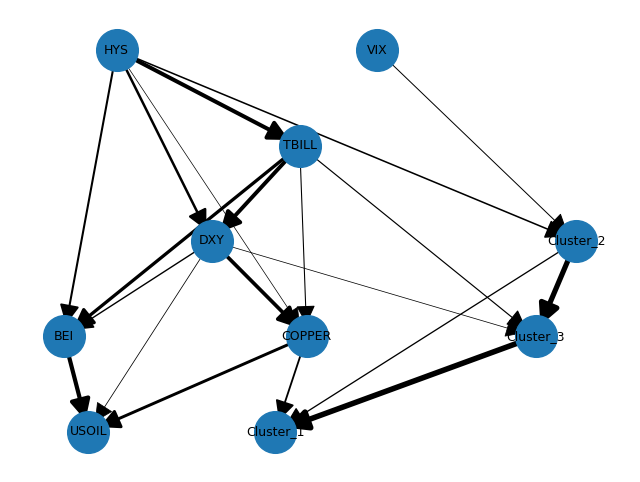

In [274]:
plot_treeish(
    G_pruned,
    figsize = (8, 6),
    arrowsize = 30,
    show_weights = False
)

### Exposure

In [276]:
def _zscore(s: pd.Series, span: int = 252) -> pd.Series:
    mu = s.ewm(span=span, adjust=False).mean()
    sd = s.ewm(span=span, adjust=False).std().replace(0, np.nan)
    return (s - mu) / sd

def cluster_signal_from_parents(
    df: pd.DataFrame,
    G_pruned: nx.DiGraph,
    cluster_vars: list[str],
    macro_z_span: int = 252,
    clip_z: float = 3.0,
    normalize_edge_weights: bool = True,
) -> pd.DataFrame:
    """
    pruned DAG의 in-edges(부모)와 weight를 이용해 각 Cluster의 일별 score(신호) 생성.
    - 입력 df: 매크로+클러스터 컬럼이 모두 있는 feature matrix (인덱스=DatetimeIndex)
    - 매크로 변수는 z-score(ewm)로 정규화해서 scale 문제를 줄임
    - 부모가 클러스터인 경우(Cluster->Cluster)는 그 부모 신호를 사용(재귀)해야 하므로,
      위상정렬(topological order) 기준으로 순차 계산.
    """
    X = df.copy()

    # 매크로 후보: 클러스터 제외한 나머지 중 그래프에 존재하는 것
    macro_like = [c for c in X.columns if (c in G_pruned.nodes) and (c not in cluster_vars)]

    # 매크로는 z-score로 스케일 정리
    Z = pd.DataFrame(index=X.index)
    for c in macro_like:
        z = _zscore(X[c].astype(float), span=macro_z_span).clip(-clip_z, clip_z)
        Z[c] = z

    # 클러스터 score 저장
    S = pd.DataFrame(index=X.index, columns=cluster_vars, dtype=float)

    # DAG라고 가정(아니면 아래에서 실패 가능)
    order = list(nx.topological_sort(G_pruned))

    # 클러스터 노드만, 위상정렬 순서대로 계산
    for node in order:
        if node not in cluster_vars:
            continue
        parents = list(G_pruned.predecessors(node))
        if len(parents) == 0:
            S[node] = 0.0
            continue

        weights = []
        parent_series = []
        for p in parents:
            w = float(G_pruned[p][node].get("weight", 1.0))
            weights.append(w)

            if p in cluster_vars:
                # 부모가 클러스터면, 이미 계산된 S[p]를 사용
                parent_series.append(S[p].astype(float))
            else:
                # 부모가 매크로면 z-score된 Z[p] 사용
                if p not in Z.columns:
                    # df에 없거나 그래프/df mismatch면 0 처리
                    parent_series.append(pd.Series(0.0, index=X.index))
                else:
                    parent_series.append(Z[p].astype(float))

        w = np.array(weights, dtype=float)

        if normalize_edge_weights:
            denom = np.sum(np.abs(w))
            if denom > 0:
                w = w / denom

        # score_t = sum_j w_j * parent_j_t
        s = np.zeros(len(X.index), dtype=float)
        for wj, sj in zip(w, parent_series):
            s += wj * sj.to_numpy()

        S[node] = s

    return S

def weights_from_cluster_scores(
    cluster_scores: pd.DataFrame,
    rebalance: str = "M",          # "M" 월말 리밸런싱
    long_only: bool = True,
    cash_node: str | None = None,  # "CASH" 같은 현금 노드 쓰려면 지정
    temperature: float = 1.0,      # softmax 온도
    max_weight: float = 0.80,      # 한 클러스터 최대비중
    min_weight: float = 0.0,       # 롱온리면 0
) -> pd.DataFrame:
    """
    Cluster score -> 포트폴리오 비중.
    기본: softmax(score/temperature)로 양의 비중 생성 (롱온리)
    """
    S = cluster_scores.copy().astype(float)

    # 리밸런싱 시점 샘플링: 월말 값 사용
    S_reb = S.resample(rebalance).last()

    if long_only:
        # softmax
        X = (S_reb / max(temperature, 1e-12)).to_numpy()
        X = X - X.max(axis=1, keepdims=True)  # 안정화
        W = np.exp(X)
        W = W / W.sum(axis=1, keepdims=True)
        W = pd.DataFrame(W, index=S_reb.index, columns=S_reb.columns)
    else:
        # 롱숏이면 score를 그대로 사용 후 L1 정규화 (원하면 수정)
        W = S_reb.copy()
        denom = W.abs().sum(axis=1).replace(0, np.nan)
        W = W.div(denom, axis=0).fillna(0.0)

    # 클리핑 + 재정규화
    W = W.clip(lower=min_weight, upper=max_weight)
    W = W.div(W.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)

    # 현금 노드 추가(선택): (1 - sum(weights))를 현금으로
    if cash_node is not None:
        cash = 1.0 - W.sum(axis=1)
        W[cash_node] = cash.clip(lower=0.0)
        # 다시 정규화
        W = W.div(W.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)

    # 일별로 forward-fill해서 보유 비중 시계열로 변환
    W_daily = W.reindex(S.index).ffill().fillna(method="bfill")
    return W_daily

cluster_vars = ["Cluster_1", "Cluster_2", "Cluster_3"]

# 1) DAG weight 기반 클러스터 신호 생성
cluster_scores = cluster_signal_from_parents(
    df=feature_matrix,        # 당신이 만든 final_feature_matrix/feature_matrix
    G_pruned=G_pruned,
    cluster_vars=cluster_vars,
    macro_z_span=252,
    clip_z=3.0,
    normalize_edge_weights=True
)

# 2) 신호 -> 월간 리밸런싱 비중
weights_daily = weights_from_cluster_scores(
    cluster_scores,
    rebalance="M",
    long_only=True,
    temperature=1.0,
    max_weight=0.80,
    cash_node=None
)

# 3) (선택) 클러스터 -> 실제 자산 매핑이 있으면,
#    클러스터 내 동일가중/시총가중 등으로 2단계 배분하면 됩니다.
#    예: cluster_to_assets = {"Cluster_1":[...], ...}
def expand_cluster_weights_to_assets(
    w_cluster: pd.DataFrame,
    cluster_to_assets: dict[str, list[str]],
    asset_weighting: str = "equal",   # "equal"만 기본 제공
) -> pd.DataFrame:
    """
    클러스터 비중을 클러스터 내부 자산으로 분배.
    """
    idx = w_cluster.index
    assets = sorted({a for lst in cluster_to_assets.values() for a in lst})
    W = pd.DataFrame(0.0, index=idx, columns=assets)

    for c, a_list in cluster_to_assets.items():
        if c not in w_cluster.columns:
            continue
        if len(a_list) == 0:
            continue
        if asset_weighting == "equal":
            w_in = 1.0 / len(a_list)
            for a in a_list:
                W[a] += w_cluster[c] * w_in
        else:
            raise ValueError("asset_weighting supports only 'equal' in this snippet.")
    # 정규화
    W = W.div(W.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)
    return W

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_90268/1896033660.py:96: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  S_reb = S.resample(rebalance).last()
/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_90268/1896033660.py:123: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  W_daily = W.reindex(S.index).ffill().fillna(method="bfill")


<Axes: xlabel='datetime'>

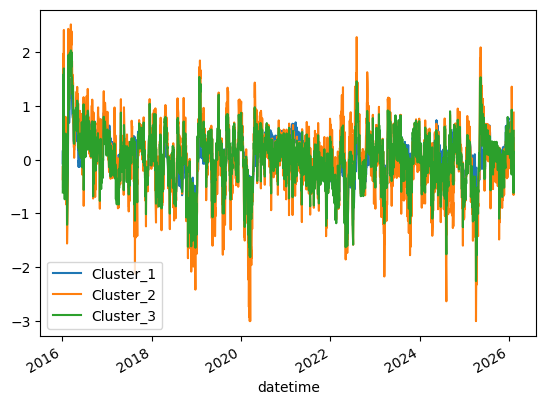

In [278]:
cluster_scores.plot()

<Axes: xlabel='datetime'>

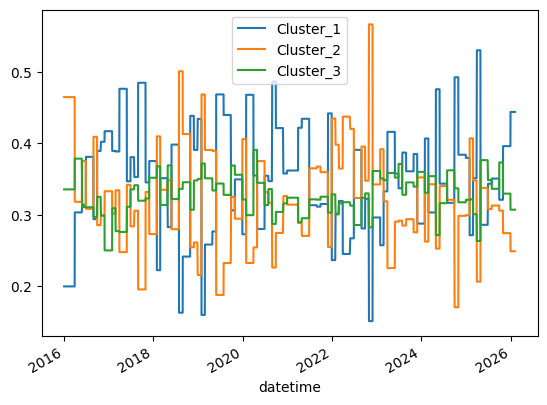

In [279]:
weights_daily.plot()

In [280]:
prices = pd.read_parquet(
    '../data/prices.parquet',
)

In [284]:
ret = prices.pct_change().loc['2016':]

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_90268/3879167194.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = prices.pct_change().loc['2016':]


In [286]:
cluster_to_assets = {
    "Cluster_1": ["AIG","AXP","BAC","BK","BKNG","BLK","BRK.B","C","CAT","COF","COP","CSCO","CVX","DE","EMR","GD","GE","GILD","GM","GS","IBM","JPM","MET","MS","RTX","SCHW","SPG","USB","WFC","XOM"],
    "Cluster_2": ["ABBV","AMGN","AMT","BA","BMY","CL","CMCSA","CVS","DIS","DUK","FDX","INTC","JNJ","KO","LMT","MCD","MDLZ","MDT","MMM","MO","MRK","NKE","PEP","PFE","PG","PM","SBUX","SO","T","TGT","UNH","UPS","VZ"],
    "Cluster_3": ["AAPL","ABT","ACN","ADBE","AMD","AMZN","AVGO","COST","CRM","DHR","GOOGL","HD","HON","INTU","ISRG","LIN","LLY","LOW","MA","META","MSFT","NEE","NFLX","NOW","NVDA","ORCL","QCOM","TMO","TMUS","TSLA","TXN","UNP","V","WMT"],
}

In [289]:
ret_clustered = pd.concat(
    [
        ret[cluster_to_assets['Cluster_1']].mean(axis = 1),
        ret[cluster_to_assets['Cluster_2']].mean(axis = 1),
        ret[cluster_to_assets['Cluster_3']].mean(axis = 1),
    ], axis = 1
)

In [290]:
ret_clustered.columns = ['Cluster_1','Cluster_2','Cluster_3']

<Axes: xlabel='datetime'>

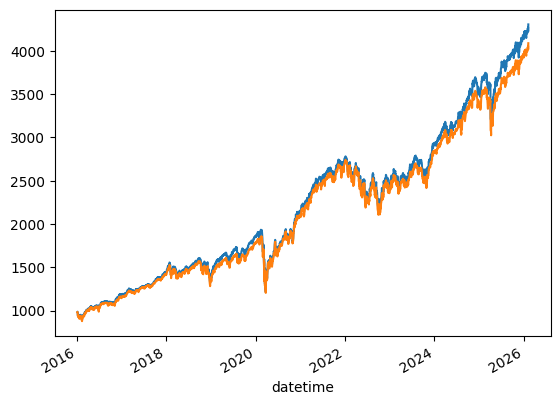

In [301]:
((1 + (ret_clustered * weights_daily).sum(axis = 1)).cumprod() * 1000).plot()
((1 + (ret_clustered).mean(axis = 1)).cumprod() * 1000).plot()
